<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Python do Zero**
*by [sigmoidal.ai](https://sigmoidal.ai)*

---

# Analisando sua Caixa de Emails



Nessa aula, veremos como acessar, baixar e trabalhar com os dados que recebemos por e-mail.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mailbox
import re
import pytz
import seaborn as sns

In [3]:
!unzip /content/drive/MyDrive/DataScience/Sigmoidal/PDZ/takeout-20210510T211857Z-001.zip

Archive:  /content/drive/MyDrive/DataScience/Sigmoidal/PDZ/takeout-20210510T211857Z-001.zip
  inflating: Takeout/E-mail/Configurações do usuário/Assinaturas.json  
  inflating: Takeout/E-mail/Todos os e-mails, incluindo Spam e Lixeira.mbox  
  inflating: Takeout/navegador_arquivo.html  


In [4]:
# carregando o arquivo
mbox = mailbox.mbox("/content/Takeout/E-mail/Todos os e-mails, incluindo Spam e Lixeira.mbox")

In [5]:
# visualizando as chaves
mbox[0].keys()

['X-GM-THRID',
 'X-Gmail-Labels',
 'Delivered-To',
 'Received',
 'X-Google-Smtp-Source',
 'X-Received',
 'ARC-Seal',
 'ARC-Message-Signature',
 'ARC-Authentication-Results',
 'Return-Path',
 'Received',
 'Received-SPF',
 'Authentication-Results',
 'Received',
 'DKIM-Signature',
 'DKIM-Signature',
 'Return-Path',
 'X-HS-Cid',
 'List-Unsubscribe',
 'Date',
 'From',
 'Reply-To',
 'To',
 'Message-ID',
 'Subject',
 'MIME-Version',
 'Content-Type',
 'Precedence',
 'X-Report-Abuse-To',
 'Feedback-ID']

## Criando o Data Frame
Para que possamos trabalhar melhor com esses dados, vamos extrair os mesmos, salvá-los em um dicionário e construir com ele um data frame.

Para isso, vamos criar um dicionário, onde as chaves são as informações que queremos puxar, e os valores serão as entradas de cada e-mail, para cada variável de interesse.

Criaremos um loop for, para percorrer nosso arqvuio mbox, e pra cada mensagem, pegar as informações e adicioná-las aoo nosso dicionário.

In [6]:
# criando o dicionário
email_dict = {
    'date':[],
    'from':[],
    'to':[],
    'subject':[],
    'labels':[]
}

#coletando os dados
for message in mbox:
  email_dict['date'].append(message['date'])
  email_dict['from'].append(message['from'])
  email_dict['to'].append(message['to'])
  email_dict['subject'].append(message['subject'])
  email_dict['labels'].append(message['X-Gmail-Labels'])


In [7]:
# transformando em dataframe
df = pd.DataFrame(email_dict)

In [8]:
# visualizando as primeiras entradas
df.head()

,date,from,to,subject,labels
0,"Fri, 7 May 2021 09:28:27 -0300",Suno Research <suno@suno.com.br>,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
1,"Mon, 03 May 2021 07:27:21 -0500","""Felipe Santana"" <contato@minerandodados.com.br>",=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
2,"Mon, 10 May 2021 21:10:44 +0000 (UTC)",LinkedIn <jobs-listings@linkedin.com>,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_redes_so..."
3,"Wed, 5 May 2021 16:46:23 +0000",Inter <no-reply@bancointer.com.br>,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
4,"Mon, 03 May 2021 22:30:10 +0000 (UTC)","""Udacity"" <support@udacity.com>",=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_promo=C3..."


In [9]:
# verificando os tipos
df.dtypes

date       object
from       object
to         object
subject    object
labels     object
dtype: object

Ao verificar os tipos das variáveis, já conseguimos perceber que precisaremos trablhar a coluna `date`. Essa coluna nos traz informações de data, mas está em formato `object`, é uma string.

Portanto, vamos converter para o formato `datetime`. Entretanto, essa coluna nos trás informácões de Time Zones, e precisamos passar o parâmetro `utc=True`, para que a conversão possa ser feita corretamente.

In [10]:
# convertendo date para datetime
df['date'] = pd.to_datetime(df['date'], utc=True, errors ='coerce')

In [11]:
# verificando as primeiras entradas
df.head()

,date,from,to,subject,labels
0,2021-05-07 12:28:27+00:00,Suno Research <suno@suno.com.br>,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
1,2021-05-03 12:27:21+00:00,"""Felipe Santana"" <contato@minerandodados.com.br>",=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
2,2021-05-10 21:10:44+00:00,LinkedIn <jobs-listings@linkedin.com>,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_redes_so..."
3,2021-05-05 16:46:23+00:00,Inter <no-reply@bancointer.com.br>,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
4,2021-05-03 22:30:10+00:00,"""Udacity"" <support@udacity.com>",=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_promo=C3..."


Excelente! Já temos nossos dados no tipo que precisamos. Entretanto, ainda existe uma transformação que precisa ser feita. 

Precisamos que a informação de *time zone* esteja condizente com a Time Zone que nos encontramos. Para isso, aplicaremos uma função *lambda* para aplicar às entradas o método timezone da biblioteca `pytz` para que possamos ter a informação correta de *time zone*.

- Como a função que usamos para colocar no horário de São Paulo não aceitam entradas vazias, precisamos fazer a limpeza antes.

- Abaixo, ao verificamos a presença de dados ausentes. Como a quantidade é pequena, vamos excluir essas linhas.

In [12]:
# verificando entradas vazias
df.isnull().sum()

date       102
from         0
to         105
subject    101
labels       0
dtype: int64

In [13]:
# excluindo as linhas
df.dropna(how='any', inplace=True)

In [14]:
# verificando novamente
df.isnull().sum()

date       0
from       0
to         0
subject    0
labels     0
dtype: int64

In [15]:
# transformando time zone
df['date'] = df['date'].apply(lambda x: x.astimezone(pytz.timezone('America/Sao_Paulo')))

In [16]:
# verificando o resultado
df.head()

,date,from,to,subject,labels
0,2021-05-07 09:28:27-03:00,Suno Research <suno@suno.com.br>,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
1,2021-05-03 09:27:21-03:00,"""Felipe Santana"" <contato@minerandodados.com.br>",=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
2,2021-05-10 18:10:44-03:00,LinkedIn <jobs-listings@linkedin.com>,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_redes_so..."
3,2021-05-05 13:46:23-03:00,Inter <no-reply@bancointer.com.br>,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
4,2021-05-03 19:30:10-03:00,"""Udacity"" <support@udacity.com>",=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_promo=C3..."


## Limpeza de Strings

Ao verificar os dados acima, conseguimos perceber que temos algumas entradas bastante confusas, onde o entendimento do que, de fato, é informação relevante fica comprometido.

<center><img width="50%" src="https://image.freepik.com/free-photo/housekeeping-concept-with-hand-holding-cloth_23-2147699396.jpg"></center>

Por isso, é importante que façamos uma limpeza dessas entradas, utilizando as técnicas de manipulação de strings que aprendemos nos módulos anteriores. 

A primeira coisa que vamos fazer é limpar os e-mails.

Para isso, vamos criar uma função para retirar tudo aquilo que não faz parte do endereço de e-mail, e aplicar a mesma nas colunas `to` e `from`.

In [17]:
df.dtypes

date       datetime64[ns, America/Sao_Paulo]
from                                  object
to                                    object
subject                               object
labels                                object
dtype: object

In [18]:
# criando a função
def extrair_email(string_email):
    email = re.findall(r'<(.+?)>', string_email)
    if email:
        return email[0]
    else:
        return string_email


In [19]:
# aplicando a função
df['from'] = df['from'].apply(extrair_email)

In [20]:
# verificando os resultados
df.head()

,date,from,to,subject,labels
0,2021-05-07 09:28:27-03:00,suno@suno.com.br,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
1,2021-05-03 09:27:21-03:00,contato@minerandodados.com.br,=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
2,2021-05-10 18:10:44-03:00,jobs-listings@linkedin.com,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_redes_so..."
3,2021-05-05 13:46:23-03:00,no-reply@bancointer.com.br,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,"=?UTF-8?Q?Caixa_de_entrada,Importante,A?=\r\n ..."
4,2021-05-03 19:30:10-03:00,support@udacity.com,=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,"=?UTF-8?Q?Caixa_de_entrada,Categoria:_promo=C3..."


Agora, iremos fazer um processo parecido para limpar a coluna `label`.

Criaremos uma função que retire as informações desnecessárias, divida os itens por vírgula, e retorne apenas o primeiro item, que é o item de interesse para nós.

In [21]:
# criando a função
def extrair_label(string_labels):
    return string_labels.replace("=?UTF-8?Q?", "").split(",")[0]
    

In [22]:
# aplicando a função
df["labels"] = df["labels"].apply(extrair_label)

In [23]:
# verificando os resultados
df.head()

,date,from,to,subject,labels
0,2021-05-07 09:28:27-03:00,suno@suno.com.br,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,Caixa_de_entrada
1,2021-05-03 09:27:21-03:00,contato@minerandodados.com.br,=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,Caixa_de_entrada
2,2021-05-10 18:10:44-03:00,jobs-listings@linkedin.com,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,Caixa_de_entrada
3,2021-05-05 13:46:23-03:00,no-reply@bancointer.com.br,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,Caixa_de_entrada
4,2021-05-03 19:30:10-03:00,support@udacity.com,=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,Caixa_de_entrada


## Análise Exploratória

Agora que nossos dados foram adquiridos, carregados e limpos, eles estão prontos para serem analisados!

<center><img width="50%" src="https://image.freepik.com/free-photo/business-presentation-laptop-screen_53876-13516.jpg"></center>

A parte que mais demanda nosso tempo e atenção é a Análise Exploratória, pois é aqui que vamos transformar dados em informação, encontrar isights que farão a diferença em nosso projetos.

A primeira análise que faremos será em relação aos endereços que nos enviam e-mail. Qual foi o endereço que mais me enviou e-mails?

In [24]:
# verificando endereços que mais enviaram e-mail para minha caixa entrada
df[df["labels"] == "Caixa_de_entrada"]["from"].value_counts()[:5]

naoresponda@peixeurbano.com.br    304
start@engage.canva.com            283
noreply@youtube.com               272
todomundo@nubank.com.br           236
invitations@linkedin.com          229
Name: from, dtype: int64

Outro insight interessante é descobrir que dia da semana a recebemos mais e-mail.

Usando Python e Pandas, vamos criar uma nova coluna, que indica em que dia da semana cada e-mail foi enviado.

In [25]:
df.head()

,date,from,to,subject,labels
0,2021-05-07 09:28:27-03:00,suno@suno.com.br,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,Caixa_de_entrada
1,2021-05-03 09:27:21-03:00,contato@minerandodados.com.br,=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,Caixa_de_entrada
2,2021-05-10 18:10:44-03:00,jobs-listings@linkedin.com,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,Caixa_de_entrada
3,2021-05-05 13:46:23-03:00,no-reply@bancointer.com.br,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,Caixa_de_entrada
4,2021-05-03 19:30:10-03:00,support@udacity.com,=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,Caixa_de_entrada


In [26]:
# criando uma variávei de dia da semana
df["weekday"] = df["date"].dt.weekday

In [27]:
# verificando o resultado
df.head()

,date,from,to,subject,labels,weekday
0,2021-05-07 09:28:27-03:00,suno@suno.com.br,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,Caixa_de_entrada,4
1,2021-05-03 09:27:21-03:00,contato@minerandodados.com.br,=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,Caixa_de_entrada,0
2,2021-05-10 18:10:44-03:00,jobs-listings@linkedin.com,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,Caixa_de_entrada,0
3,2021-05-05 13:46:23-03:00,no-reply@bancointer.com.br,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,Caixa_de_entrada,2
4,2021-05-03 19:30:10-03:00,support@udacity.com,=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,Caixa_de_entrada,0


Com a coluna criada, vamos transformar esses números em uma informação mais fácil de digerir e interpretar.

A transformação que fizemos retorna Segunda-Feira como o primeiro dia, portanto, o dia associado ao valor `0`, é Segunda-Feira, e assim sucessivamente.

Vamos criar um dicionário, onde associaremos para as chaves, valores em formato de string para os dias da semana, e transformar nossa coluna com esse dicionário.

In [28]:
# criando dicionário
dias_semana = {0:"Segunda", 1:"Terça", 2:"Quarta",3:"Quinta", 4:"Sexta", 5:"Sábado", 6:"Domingo"}

# transformando a coluna
df["weekday"] = df["weekday"].replace(dias_semana)

In [29]:
# verificando o resultado
df.head()

,date,from,to,subject,labels,weekday
0,2021-05-07 09:28:27-03:00,suno@suno.com.br,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,Caixa_de_entrada,Sexta
1,2021-05-03 09:27:21-03:00,contato@minerandodados.com.br,=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,Caixa_de_entrada,Segunda
2,2021-05-10 18:10:44-03:00,jobs-listings@linkedin.com,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,Caixa_de_entrada,Segunda
3,2021-05-05 13:46:23-03:00,no-reply@bancointer.com.br,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,Caixa_de_entrada,Quarta
4,2021-05-03 19:30:10-03:00,support@udacity.com,=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,Caixa_de_entrada,Segunda


Agora que temos todas as informações necessárias, podemos usar a biblioteca `seaborn` para plotar um `countplot` e nos mostrar em qual dia da semana recebemos mais e-mails.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


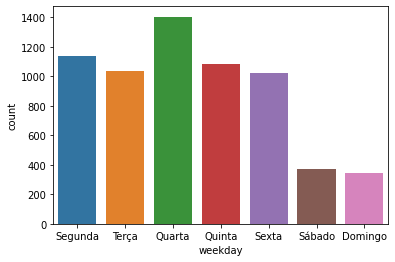

In [30]:
# plotando o countplot
sns.countplot(df["weekday"], order=["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]);

Agora já sabemos que a **Quarta-Feira** traz um volume maior de e-mails do que qualquer outro dia da semana. Mas qual será o horário que mais recebemos e-mails?

Podemos fazer um processo parecido com o que fizemos de dias da semana para criar uma variável que nos indica a hora em que o e-mail foi recebido.

Assim, conseguimos fazer uma análise sememlhante à que fizemos sobre os dias.

In [31]:
# coletando as horas
df["hora"] = df["date"].dt.hour

In [32]:
# verificando o resultado
df.head()

,date,from,to,subject,labels,weekday,hora
0,2021-05-07 09:28:27-03:00,suno@suno.com.br,jofdorneles@gmail.com,Suno Call: Por que a complexidade nos atrai?,Caixa_de_entrada,Sexta,9
1,2021-05-03 09:27:21-03:00,contato@minerandodados.com.br,=?utf-8?Q?Jo=C3=A3o_Tournier?=\r\n <jofdornele...,Analisando dados do mercado financeiro com Python,Caixa_de_entrada,Segunda,9
2,2021-05-10 18:10:44-03:00,jobs-listings@linkedin.com,=?UTF-8?Q?Jo=C3=A3o_Felipe_Dorneles_Tournier?=...,=?UTF-8?Q?Exact_Sales_est=C3=A1_procurando:?=\...,Caixa_de_entrada,Segunda,18
3,2021-05-05 13:46:23-03:00,no-reply@bancointer.com.br,jofdorneles@gmail.com,Recebemos o pagamento da sua fatura,Caixa_de_entrada,Quarta,13
4,2021-05-03 19:30:10-03:00,support@udacity.com,=?UTF-8?B?Sm/Do28gRmVsaXBlIERvcm5lbGVz?= <jofd...,=?UTF-8?B?VGhlcmXigJlzIHN0aWxsIHRpbWUgdG8gZ2V0...,Caixa_de_entrada,Segunda,19


Pronto! Agora basta plotar um countplot, como fizemos anteriormente.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


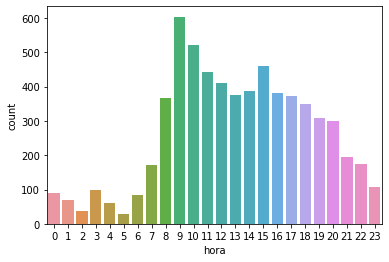

In [33]:
# plotando o gráfico
sns.countplot(df["hora"]);

**One more thing... exportando para Excel!**



In [34]:
# converter para formato de data que o Excel aceita
df['date'] = df['date'].apply(lambda a: pd.to_datetime(a).date()) 

In [35]:
df.to_excel("meu_gmail.xlsx", index=False)